In [21]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm_notebook

from datetime import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
from matplotlib import rc, font_manager, rcParams
font_name = font_manager.FontProperties(fname = "c:/windows/fonts/malgun.ttf").get_name()
rc("font", family = font_name)
rcParams["axes.unicode_minus"] = False

import seaborn as sns

import copy

import statsmodels.api as sm
from loess import loess_1d

import xgboost

# path 설정
data_path = str(Path.cwd().parent / "GS/0. data")
intermediate_path = str(Path.cwd().parent / "0. data" / "intermediate")

pd.set_option("display.max_columns", False)
np.set_printoptions(suppress = True)
from csaps import csaps

import warnings
warnings.filterwarnings('ignore')

# BTC 시장에 HP 필터 적용하기: 트렌드 분석

## 1. 소개

거시경제학에서, 실물 경기 변동(RBC) 모델은 경제가 호황인지 불황인지를 설명하고 감지하는 데 자주 사용됩니다. 이러한 개념에 영감을 받아, BTC 가격 시장에도 유사한 접근 방식을 적용할 수 있을지 궁금했습니다. 호드릭-프레스콧(HP) 필터는 특히 실물 경기 변동(RBC) 모델에서 추세를 추정하는데 사용됩니다. 이를 사용하여 BTC 가격의 주요 트렌드 요소를 식별함으로써, 트렌드 위의 가격은 과대평가(overpricing)를, 트렌드 아래의 가격은 과소평가(underpricing)를 나타낼 수 있습니다.

이 개념은 이동평균선(SMA, Simple Moving Average) 또는 지수이동평균선(EMA, Exponential Moving Average) 방법론을 사용하는 잘 알려진 거래 전략과 유사합니다. 이러한 방법에서는 이동평균선을 기준으로 가격이 저평가되었는지 고평가되었는지를 판단합니다.

HP 필터의 중요한 차이점은 미래의 값을 사용하여 트렌드를 구성한다는 것입니다. 따라서 실시간으로 적용하거나 공정한 접근 방식을 위해, 우리는 한쪽만 사용하는 HP 필터(one-sided HP filter)를 사용할 것입니다.

## 2. HP 필터 소개

Hodrick-Prescott (HP) 필터는 시간의 흐름에 따라 데이터 시계열을 추세와 순환 성분으로 분해하는 방법입니다. 주로 거시경제학에서 경제활동의 추세와 순환을 분석하기 위해 사용됩니다. HP 필터는 주어진 시계열 \( y_t \)를 추세 성분 \( \tau_t \)와 순환 성분 \( c_t \)로 분해하여 \( y_t = \tau_t + c_t \) 형태로 표현합니다.

HP 필터의 목적은 순환 성분 \( c_t \)를 최소화하면서 추세 성분 \( \tau_t \)가 부드럽게 변화하도록 하는 것입니다. 이는 다음과 같은 최적화 문제로 표현됩니다:

$$
\min_{\tau} \sum_{t=1}^{T} \left( (y_t - \tau_t)^2 + \lambda \left( (\tau_{t+1} - \tau_t) - (\tau_t - \tau_{t-1}) \right)^2 \right)
$$

여기서 \(\lambda\)는 부드러움을 제어하는 파라미터로, 보통 \(\lambda = 1600\)이 많이 사용됩니다.

## 3. 한국 실질 GDP에 HP 필터 적용

이제 파이썬을 사용하여 한국 실질 GDP에 HP 필터를 적용하고, 결과를 시각화해보겠습니다.


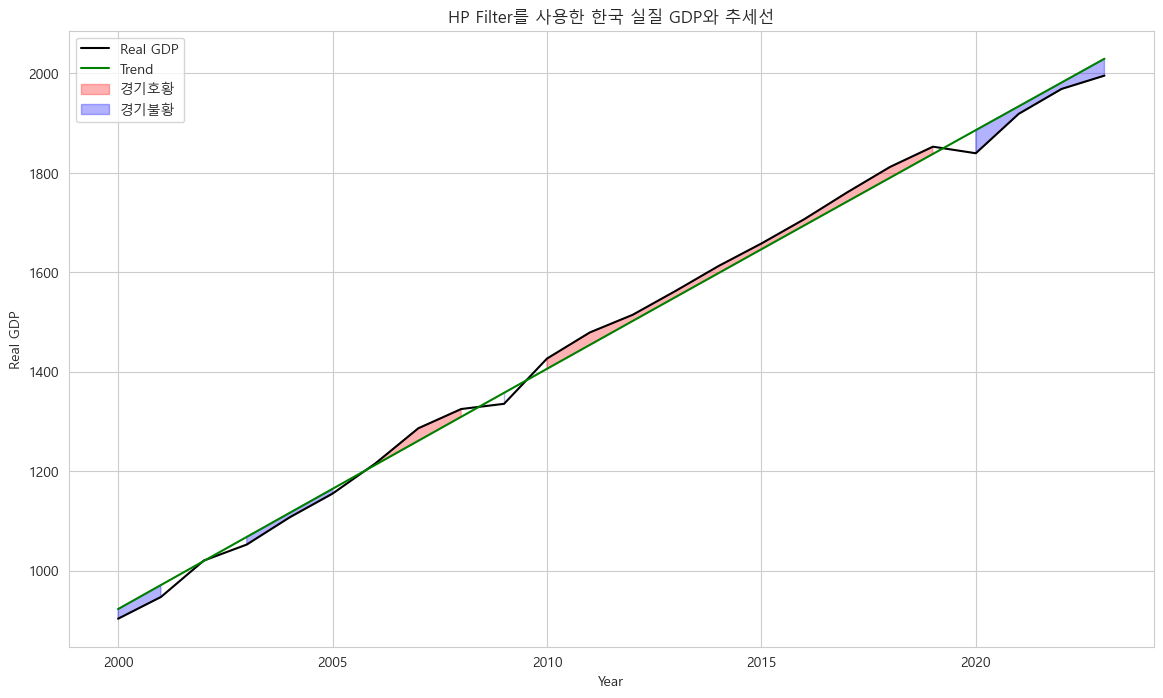

In [22]:
import pandas as pd
import numpy as np

# 한국 실질 GDP 데이터
data = {
    'Year': [1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 
             1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 
             1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 
             2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'Real_GDP': [21.7, 22.9, 23.1, 25.2, 26.9, 28.4, 29.1, 31.1, 32.3, 35.2, 38.5, 41.4, 46.3, 50.5, 57.2, 65.5, 72.1, 
                 79.7, 85.5, 98.2, 107.5, 116.0, 131.3, 147.5, 163.6, 177.8, 174.9, 187.6, 203.2, 230.4, 254.7, 274.7, 
                 305.8, 344.7, 386.0, 413.3, 454.1, 503.1, 534.3, 571.0, 624.0, 683.9, 737.9, 783.4, 743.3, 828.5, 903.6, 
                 947.4, 1020.6, 1052.7, 1107.4, 1155.1, 1215.9, 1286.5, 1325.2, 1335.7, 1426.6, 1479.2, 1514.7, 1562.7, 
                 1612.7, 1658.0, 1706.9, 1760.8, 1812.0, 1852.7, 1839.5, 1918.7, 1968.8, 1995.6]
}
# 데이터프레임 생성
gdp_data = pd.DataFrame(data)
gdp_data.set_index('Year', inplace=True)
gdp_data = gdp_data.loc[gdp_data.index>=2000]
# HP 필터 적용
gdp_cycle, gdp_trend = sm.tsa.filters.hpfilter(gdp_data['Real_GDP'], lamb=14400)

# 호황 및 불황 구간 설정
booms = gdp_data[gdp_data['Real_GDP'] > gdp_trend]
recessions = gdp_data[gdp_data['Real_GDP'] < gdp_trend]

# 플롯 생성
plt.figure(figsize=(14, 8))
plt.plot(gdp_data.index, gdp_data['Real_GDP'], label='Real GDP', color='black')
plt.plot(gdp_data.index, gdp_trend, label='Trend', color='green')

# 호황 및 불황 구간 표시
plt.fill_between(gdp_data.index, gdp_data['Real_GDP'], gdp_trend, where=(gdp_data['Real_GDP'] > gdp_trend), color='red', alpha=0.3, label='경기호황')
plt.fill_between(gdp_data.index, gdp_data['Real_GDP'], gdp_trend, where=(gdp_data['Real_GDP'] < gdp_trend), color='blue', alpha=0.3, label='경기불황')

plt.title('HP Filter를 사용한 한국 실질 GDP와 추세선')
plt.xlabel('Year')
plt.ylabel('Real GDP')
plt.legend()
plt.show()


# BTC 일별 종가 자료에 SMA, EMA, HP 필터 적용

## 설명

이 문서에서는 Pyupbit의 `ohlcv` 메서드를 사용하여 BTC의 일별 종가 데이터를 불러오고, 이를 바탕으로 1) 단순 이동 평균(SMA), 2) 지수 이동 평균(EMA), 3) HP 필터를 적용하여 결과를 시각화합니다.

### 1. 데이터 불러오기

Pyupbit 라이브러리를 사용하여 BTC의 일별 종가 데이터를 불러옵니다. `pyupbit.get_ohlcv` 메서드를 사용하여 데이터를 가져옵니다.

### 2. 단순 이동 평균(SMA)

단순 이동 평균은 일정 기간 동안의 평균 가격을 계산합니다. 20일 단순 이동 평균을 계산하기 위해 `rolling` 메서드를 사용합니다.

### 3. 지수 이동 평균(EMA)

지수 이동 평균은 최근 가격에 더 많은 가중치를 부여하여 평균을 계산합니다. 20일 지수 이동 평균을 계산하기 위해 `ewm` 메서드를 사용합니다.

### 4. HP 필터 적용

Hodrick-Prescott (HP) 필터는 시계열 데이터를 추세 성분과 순환 성분으로 분해합니다. `statsmodels` 라이브러리의 `hpfilter`를 사용하여 BTC 종가 데이터에 HP 필터를 적용하고 추세 성분을 추출합니다.

### 5. 결과 시각화

원본 종가 데이터와 함께 SMA, EMA, HP 필터 추세를 시각화합니다. 이를 통해 가격이 이동 평균 또는 추세에 비해 과대평가 또는 과소평가되었는지를 분석할 수 있습니다.


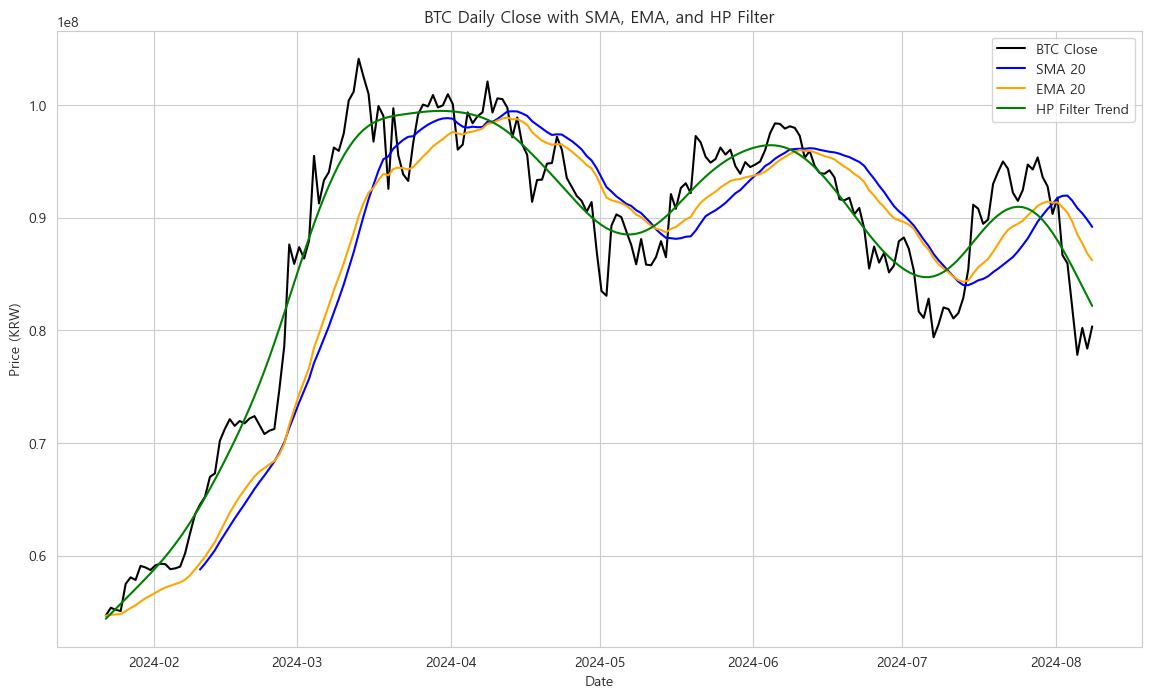

In [23]:
import pyupbit
import statsmodels.api as sm

# Pyupbit를 사용하여 BTC 일별 종가 데이터 불러오기
btc_data = pyupbit.get_ohlcv("KRW-BTC", interval="day")

# SMA (단순 이동 평균) 계산
sma_20 = btc_data['close'].rolling(window=20).mean()

# EMA (지수 이동 평균) 계산
ema_20 = btc_data['close'].ewm(span=20, adjust=False).mean()

# HP 필터 적용
gdp_cycle, gdp_trend = sm.tsa.filters.hpfilter(btc_data['close'], lamb=1600)

# 데이터프레임에 추가
btc_data['SMA_20'] = sma_20
btc_data['EMA_20'] = ema_20
btc_data['HP_Trend'] = gdp_trend

# 플롯 생성
plt.figure(figsize=(14, 8))
plt.plot(btc_data.index, btc_data['close'], label='BTC Close', color='black')
plt.plot(btc_data.index, btc_data['SMA_20'], label='SMA 20', color='blue')
plt.plot(btc_data.index, btc_data['EMA_20'], label='EMA 20', color='orange')
plt.plot(btc_data.index, btc_data['HP_Trend'], label='HP Filter Trend', color='green')

plt.title('BTC Daily Close with SMA, EMA, and HP Filter')
plt.xlabel('Date')
plt.ylabel('Price (KRW)')
plt.legend()
plt.show()


# BTC 일별 종가 자료에 SMA, EMA, 원사이드 HP 필터 적용

## 설명

이 문서에서는 Pyupbit의 `ohlcv` 메서드를 사용하여 BTC의 일별 종가 데이터를 불러오고, 이를 바탕으로 1) 단순 이동 평균(SMA), 2) 지수 이동 평균(EMA), 3) 원사이드 HP 필터를 적용하여 결과를 시각화합니다.

### 1. 데이터 불러오기

Pyupbit 라이브러리를 사용하여 BTC의 일별 종가 데이터를 불러옵니다. `pyupbit.get_ohlcv` 메서드를 사용하여 데이터를 가져옵니다.

### 2. 단순 이동 평균(SMA)

단순 이동 평균은 일정 기간 동안의 평균 가격을 계산합니다. 20일 단순 이동 평균을 계산하기 위해 `rolling` 메서드를 사용합니다.

### 3. 지수 이동 평균(EMA)

지수 이동 평균은 최근 가격에 더 많은 가중치를 부여하여 평균을 계산합니다. 20일 지수 이동 평균을 계산하기 위해 `ewm` 메서드를 사용합니다.

### 4. 원사이드 HP 필터 적용

원사이드 HP 필터는 현재 시점까지의 데이터만을 사용하여 추세를 추정합니다. 이를 위해 반복적으로 현재 시점까지의 데이터에 HP 필터를 적용하여 추세 성분을 추출합니다.

### 5. 결과 시각화

원본 종가 데이터와 함께 SMA, EMA, 원사이드 HP 필터 추세를 시각화합니다. 이를 통해 가격이 이동 평균 또는 추세에 비해 과대평가 또는 과소평가되었는지를 분석할 수 있습니다.


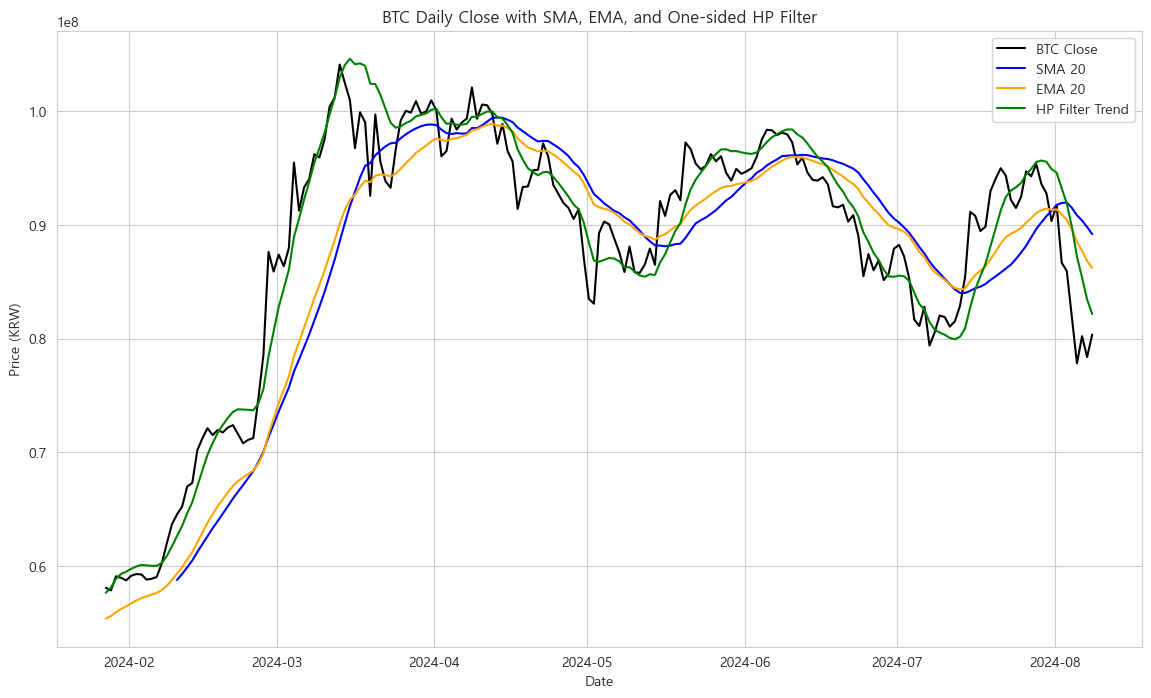

In [24]:
# Pyupbit를 사용하여 BTC 일별 종가 데이터 불러오기
btc_data = pyupbit.get_ohlcv("KRW-BTC", interval="day")

# SMA (단순 이동 평균) 계산
sma_20 = btc_data['close'].rolling(window=20).mean()

# EMA (지수 이동 평균) 계산
ema_20 = btc_data['close'].ewm(span=20, adjust=False).mean()

# 원사이드 HP 필터 적용
def one_sided_hp_filter(series, lamb=1600):
    trend = np.zeros(len(series))
    for i in range(2, len(series)):
        cycle, temp_trend = sm.tsa.filters.hpfilter(series[:i+1], lamb=lamb)
        trend[i] = temp_trend[-1]  # 현재 시점의 추세 성분만 저장
    return trend

btc_trend = one_sided_hp_filter(btc_data['close'])

# 데이터프레임에 추가
btc_data['SMA_20'] = sma_20
btc_data['EMA_20'] = ema_20
btc_data['HP_Trend'] = btc_trend

# 플롯 생성
plt.figure(figsize=(14, 8))
plt.plot(btc_data.index[5:], btc_data['close'][5:], label='BTC Close', color='black')
plt.plot(btc_data.index[5:], btc_data['SMA_20'][5:], label='SMA 20', color='blue')
plt.plot(btc_data.index[5:], btc_data['EMA_20'][5:], label='EMA 20', color='orange')
plt.plot(btc_data.index[5:], btc_data['HP_Trend'][5:], label='HP Filter Trend', color='green')

plt.title('BTC Daily Close with SMA, EMA, and One-sided HP Filter')
plt.xlabel('Date')
plt.ylabel('Price (KRW)')
plt.legend()
plt.show()


## 결론

BTC 일별 종가 데이터에 대해 단순 이동 평균(SMA), 지수 이동 평균(EMA), 원사이드 HP 필터를 적용한 결과, 각 방법론은 각기 다른 방식으로 가격의 추세를 분석할 수 있음을 보여줍니다.

- **단순 이동 평균(SMA)**: 일정 기간 동안의 평균 가격을 계산하여 단순하고 직관적인 추세 분석을 제공합니다. 가격 변동에 대한 반응이 느리지만 노이즈를 줄이는 데 효과적입니다.
- **지수 이동 평균(EMA)**: 최근 가격에 더 많은 가중치를 부여하여 빠르게 변동하는 시장 상황에 더 민감하게 반응합니다. 단기적인 추세를 분석하는 데 유용합니다.
- **원사이드 HP 필터**: 미래 값을 사용하지 않고 현재 및 과거 값만을 사용하여 추세를 추정합니다.

원사이드 HP 필터는 일반적으로 잘 작동하지만, 비교를 위한 단순이동평균이나 지수이동평균에서 윈도우 크기나 기타 파라미터를 충분히 고려하지 않았기 때문에 더 좋다고 보기에는 어려울 수 있습니다. 따라서 실제 적용 시에는 각 방법론의 특성과 목적에 맞게 적절히 선택하고, 파라미터 튜닝을 통해 최적의 결과를 얻는 것이 중요합니다.
